In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [2]:
data_url = 'D:\\DeepLearning\\learn\\DeepLearning\\data\\HousePrice\\'
train_data = pd.read_csv(data_url + 'train.csv')
test_data = pd.read_csv(data_url + 'test.csv')
train_feature = train_data.iloc[:, 1:-1]
train_flag = train_data.iloc[:, -1]
test_feature = test_data.iloc[:, 1:]
all_feature = pd.concat((train_feature, test_feature))
all_feature

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [3]:
#数据处理
indexes = all_feature.dtypes[all_feature.dtypes != 'object'].index
all_feature[indexes] = all_feature[indexes].apply(lambda x : (x-x.mean()) / (x.std()))
all_feature[indexes] = all_feature[indexes].fillna(0)
all_feature = pd.get_dummies(all_feature, dummy_na=True)

train_size = train_data.shape[0]
train_features = torch.tensor(all_feature[:train_size].values, dtype=torch.float32)
test_features = torch.tensor(all_feature[train_size:].values, dtype=torch.float32)
train_flags = torch.tensor(train_flag, dtype=torch.float32)
train_features.shape, train_flags.shape, test_features.shape

(torch.Size([1460, 331]), torch.Size([1460]), torch.Size([1459, 331]))

In [4]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

In [5]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [6]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, weight_decay=weight_decay)
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [32]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j*fold_size, (j+1)*fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train,  X_valid, y_valid

In [24]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rmse', yscale='log')
        print(f'折{i+1}, 训练logrmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

D:\anaconda3\envs\D2L\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\anaconda3\envs\D2L\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


折1, 训练logrmse0.411201, 验证log rmse0.392989
折2, 训练logrmse0.400648, 验证log rmse0.431817
折3, 训练logrmse0.405693, 验证log rmse0.415194
折4, 训练logrmse0.411859, 验证log rmse0.400768
折5, 训练logrmse0.409732, 验证log rmse0.397528
5-折验证：平均训练log rmse：0.407827, 平均验证log rmse0.407659


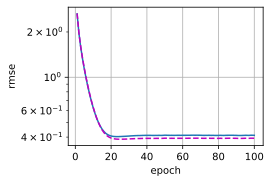

In [50]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100,15, 0, 64
train_l, valid_l = k_fold(k, train_features, train_flags, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证：平均训练log rmse：{float(train_l):f}, '
              f'平均验证log rmse{float(valid_l):f}')

In [43]:
def train_and_pre(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch', ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse: {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('D:\\DeepLearning\\learn\\DeepLearning\\data\\HousePrice\\sub.csv', index=False)

D:\anaconda3\envs\D2L\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([52])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\anaconda3\envs\D2L\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1460])) that is different to the input size (torch.Size([1460, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


训练log rmse: 0.407176


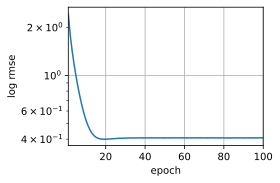

In [51]:
train_and_pre(train_features, test_features, train_flags, test_data, num_epochs, lr, weight_decay, batch_size)